<a href="https://colab.research.google.com/github/farukemrekaraca/ztm-tensorflow-machinelearning-deeplearning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-31 07:29:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-31 07:29:23 (41.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-31 07:29:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   146MB/s    in 1.1s    

2024-01-31 07:29:30 (146 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [7]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.64477676e+02 1.80477676e+02 1.96477676e+02]
   [1.64477676e+02 1.80477676e+02 1.96477676e+02]
   [1.64906250e+02 1.80263397e+02 1.96477676e+02]
   ...
   [3.76987495e+01 3.10559578e+01 3.21091576e+01]
   [3.68229904e+01 3.29285583e+01 3.39285583e+01]
   [3.30932808e+01 3.18076363e+01 3.44504585e+01]]

  [[1.63000000e+02 1.79000000e+02 1.95000000e+02]
   [1.63000000e+02 1.79000000e+02 1.95000000e+02]
   [1.63428574e+02 1.78785721e+02 1.95000000e+02]
   ...
   [3.83047943e+01 3.19977455e+01 3.61147194e+01]
   [3.76560669e+01 3.22010498e+01 3.39285583e+01]
   [3.51479378e+01 3.22953300e+01 3.36510315e+01]]

  [[1.64305801e+02 1.80305801e+02 1.96305801e+02]
   [1.65234375e+02 1.81234375e+02 1.97234375e+02]
   [1.66214920e+02 1.80851242e+02 1.97305801e+02]
   ...
   [4.16257248e+01 3.51718102e+01 4.26481667e+01]
   [3.95620117e+01 3.34964714e+01 3.60425377e+01]
   [3.96317673e+01 3.30201607e+01 3.24085503e+01]]

  ...

  [[1.10662926e+02 6.46629257e+01 7.56629257e+01]
   [1

In [12]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="globl_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_10_percent = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240131-072954
Epoch 1/5
24/24 [==============================] - 123s 4s/step - loss: 1.9167 - accuracy: 0.3987 - val_loss: 1.3265 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 76s 3s/step - loss: 1.1537 - accuracy: 0.7320 - val_loss: 0.8997 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 134s 6s/step - loss: 0.8398 - accuracy: 0.8093 - val_loss: 0.7385 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 96s 4s/step - loss: 0.7000 - accuracy: 0.8387 - val_loss: 0.6425 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 102s 4s/step - loss: 0.6082 - accuracy: 0.8427 - val_loss: 0.5795 - val_accuracy: 0.8421


In [13]:
model_0.evaluate(test_data)

35/79 [============>.................] - ETA: 1:48 - loss: 0.5853 - accuracy: 0.8482

KeyboardInterrupt: 

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [15]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 globl_average_pooling_laye  (None, 1280)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


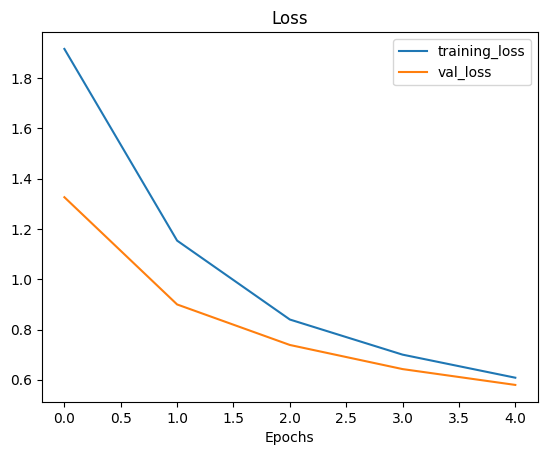

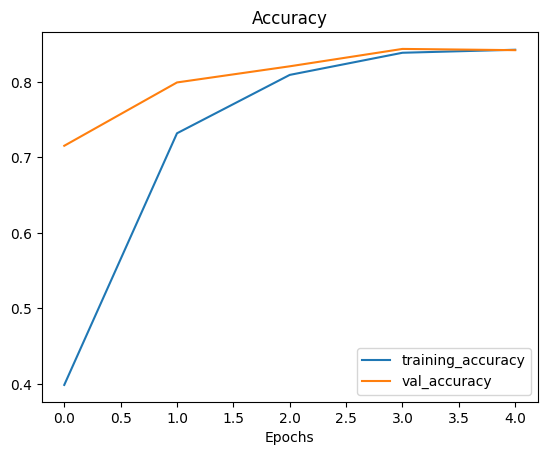

In [17]:
plot_loss_curves(history_10_percent)

In [18]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-01-31 07:42:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   114MB/s    in 1.1s    

2024-01-31 07:42:06 (114 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [20]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [21]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.rescale(1/255.) necessary for resnet50v2, efficientnet has built
], name="data_augmentation")

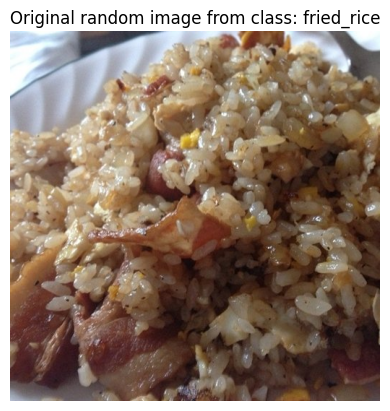

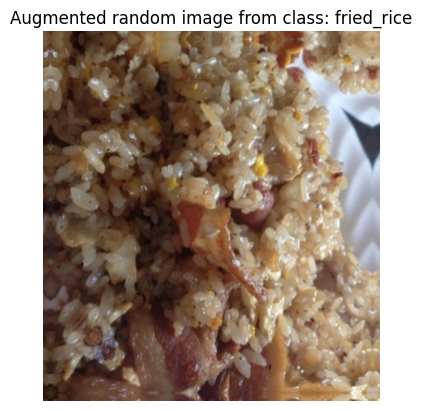

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [28]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240131-074642
Epoch 1/5
3/3 [==============================] - 154s 44s/step - loss: 2.3403 - accuracy: 0.1429 - val_loss: 2.2170 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 88s 42s/step - loss: 2.1401 - accuracy: 0.2429 - val_loss: 2.0859 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 86s 42s/step - loss: 1.9690 - accuracy: 0.3429 - val_loss: 1.9628 - val_accuracy: 0.3865
Epoch 4/5
3/3 [==============================] - 88s 43s/step - loss: 1.7586 - accuracy: 0.4857 - val_loss: 1.8930 - val_accuracy: 0.4474
Epoch 5/5
3/3 [==============================] - 87s 42s/step - loss: 1.6019 - accuracy: 0.7000 - val_loss: 1.7652 - val_accuracy: 0.5378


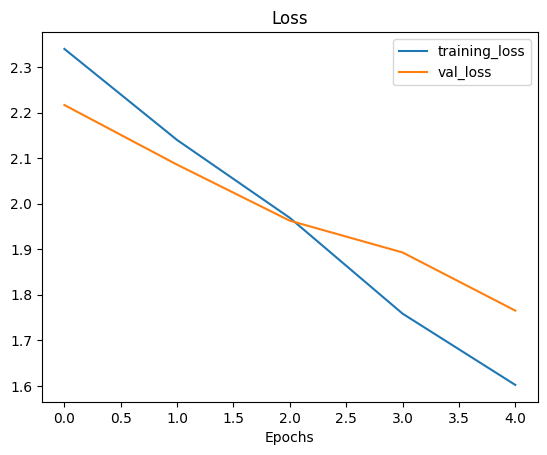

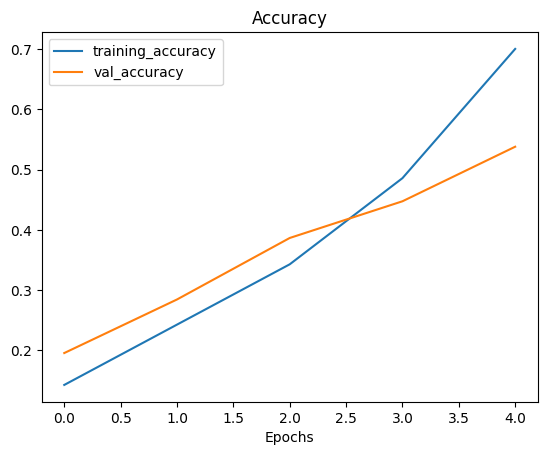

In [29]:
plot_loss_curves(history_1_percent)

In [30]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [31]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_Data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name="data_augmentation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback =

In [ ]:
model_2.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback()])